# Analyzing Load Data

In [62]:
!pip install pandas numpy scikit-learn seaborn matplotlib tensorflow keras statsmodels 

!pip install git+https://github.com/Kaggle/learntools.git
# ou pip install eo-learn-ml-tools

  Cloning https://github.com/Kaggle/learntools.git to /tmp/pip-req-build-mirk6abq
  Running command git clone --filter=blob:none --quiet https://github.com/Kaggle/learntools.git /tmp/pip-req-build-mirk6abq
  Resolved https://github.com/Kaggle/learntools.git to commit 010e3b5035354e15c073a0aca9e202c2e2beb742
  Preparing metadata (setup.py) ... done


In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
from numpy import hstack
import os 
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import ccf, adfuller, coint
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import shapiro
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from learntools.time_series.utils import plot_periodogram
from sklearn.metrics import mean_squared_error 

In [64]:
# import 
name_file = 'load.csv'
path_dir = './data/'

if os.path.exists(path_dir+name_file):
    print(f"O arquivo existe este e sera carregado.")
    data = pd.read_csv(path_dir + name_file, sep=';', index_col='eventdate')
    index = [day.split(' ')[0] for day in data.index]
    data.index = pd.to_datetime(data.index)
    print("Carregado.")

else:
    print(f'Arquivo inexistente. Tente carregar novamente.')

O arquivo existe este e sera carregado.
Carregado.


## Processing Data

In [65]:
# getting the percentage of missing data for each series
def percentage_missing(data, ):
    total = len(data)
    percentage_dict = {}
    for serie in data.columns:
        if serie == 'Date' or serie == 'eventdate':
            continue
        total_nan_value = 0
        for value in data[serie].isna():
            if value == True:
                total_nan_value += 1
        percentage = (total_nan_value/total) * 100
        print(f'{serie}: {percentage:.2f}%')    

        percentage_dict[serie] = percentage
    return percentage_dict

In [66]:
percentage = percentage_missing(data)

load_n: 2.52%
load_ne: 2.52%
load_seco: 2.52%
load_s: 2.53%
load_t: 2.52%
teq_n: 86.70%
teq_ne: 86.70%
teq_seco: 86.70%
teq_s: 86.70%
teq_t: 86.70%


In [67]:
data = data.filter(like='load')
print(data)

            load_n    load_ne  load_seco   load_s     load_t
eventdate                                                   
2003-01-01  27.734  26.847752  27.317682  25.8798  26.944809
2003-01-02  28.590  27.714286  26.936064  23.9826  26.805737
2003-01-03  28.304  27.197203  26.202597  23.3248  26.257150
2003-01-04  28.778  27.775624  26.108891  24.7216  26.846029
2003-01-05  28.662  28.208591  26.905095  26.4960  27.567922
...            ...        ...        ...      ...        ...
2025-01-20  26.336  26.837562  28.103497  26.8922  27.042315
2025-01-21  26.510  27.562637  28.594006  26.4166  27.270811
2025-01-22  26.404  27.709291  28.451748  25.7354  27.075110
2025-01-23  27.542  26.898701  26.309491  26.7080  26.864548
2025-01-24  25.208  27.112288  27.529670  26.1860  26.508990

[8060 rows x 5 columns]


In [68]:
# # para comparacao e verificar se tem dados faltantes
# # Definir data de início e fim
# data_inicio = "2003-01-01"
# data_fim = "2025-01-24"

# # Criar índice com todos os dias dentro do intervalo
# datas = pd.date_range(start=data_inicio, end=data_fim, freq='D')
# fake_data = {'fake_data': [1 for i in range(len(datas))]}

# # Criar DataFrame com índice como os dias do ano
# df = pd.DataFrame(index=datas, data=fake_data )

# # Exibir as primeiras linhas
# print(df)

## Exploratory Analysis

### Trend

In [69]:
def trend(serie, name_serie, year, window, min_periods):
    moving_average = serie.rolling(
        window=window,
        min_periods = min_periods,
        center=True
    ).mean()
    ax, figure = plt.subplots(1, 1, figsize=(12, 6))
    ax = serie[:(year*365)].plot(style='.', markersize=3, color='0.5', alpha=0.7)
    moving_average[:(year*365)].plot(ax=ax, linewidth=2, alpha=0.7)
    plt.title(name_serie)
    plt.grid()
    plt.show()


In [70]:
data.columns

Index(['load_n', 'load_ne', 'load_seco', 'load_s', 'load_t'], dtype='object')

<!--  -->
<!-- data[serie].dropna() -> data[serie].fillna(number)-->

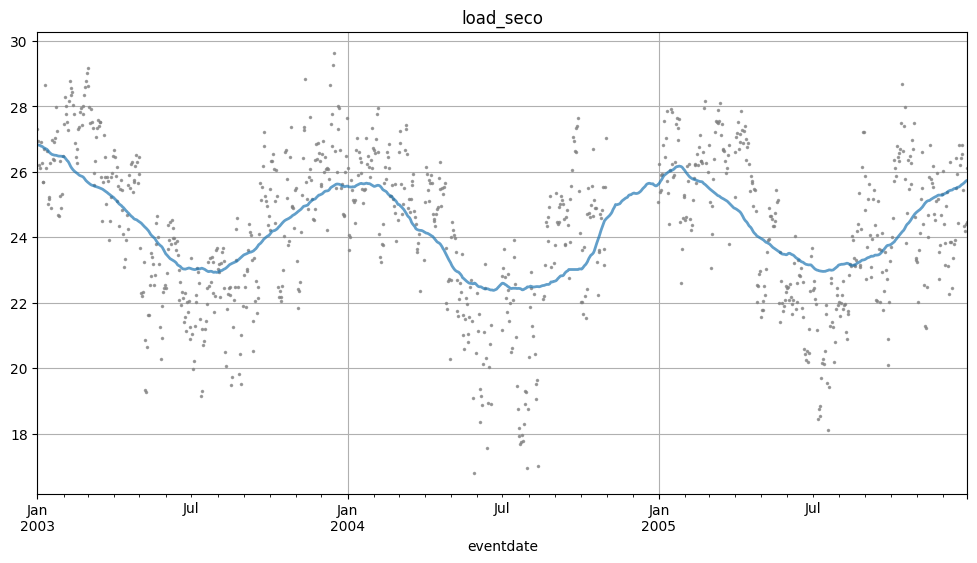

In [71]:
serie = 'load_seco'
years = 3
trend(data[serie], serie, years, 180, 90)

### Joint Analysis

In [72]:
# normalizing data
normalized_data = pd.DataFrame(MinMaxScaler().fit_transform(data), columns = data.columns, index = data.index)

In [73]:
def plot_joing_view(data, years):
    plt.figure(figsize=(12, 6))
    
    # Se o índice não for datetime, converta-o
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)
    
    plt.plot(data[365*years:], alpha=0.4)  # Reduzir a densidade dos pontos plotados

    plt.grid()
    plt.legend(data.columns)

    # Ajustar os rótulos do eixo X para evitar sobreposição
    plt.xticks(data[365*years:].index[::int(len(data[365*years:])*0.1)], rotation=45)  # Ajuste para exibir menos rótulos
    plt.show()

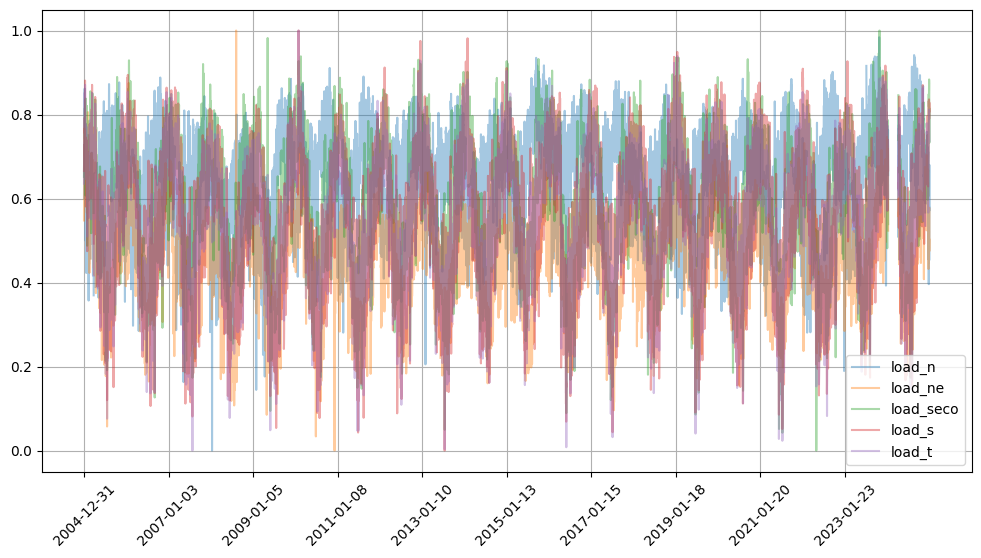

In [74]:
plot_joing_view(normalized_data, 2)

In [75]:
def plot_two_by_two(data, serie1, serie2, years):
    let_data = pd.DataFrame() 
    let_data[serie1] = data[serie1]
    let_data[serie2] = data[serie2]

    plt.figure(figsize=(12,6))
    plt.plot(let_data[:365*years], alpha=0.4)
    plt.title(serie1 + ' - ' + serie2)
    plt.grid()
    plt.legend(let_data.columns)
    plt.show()

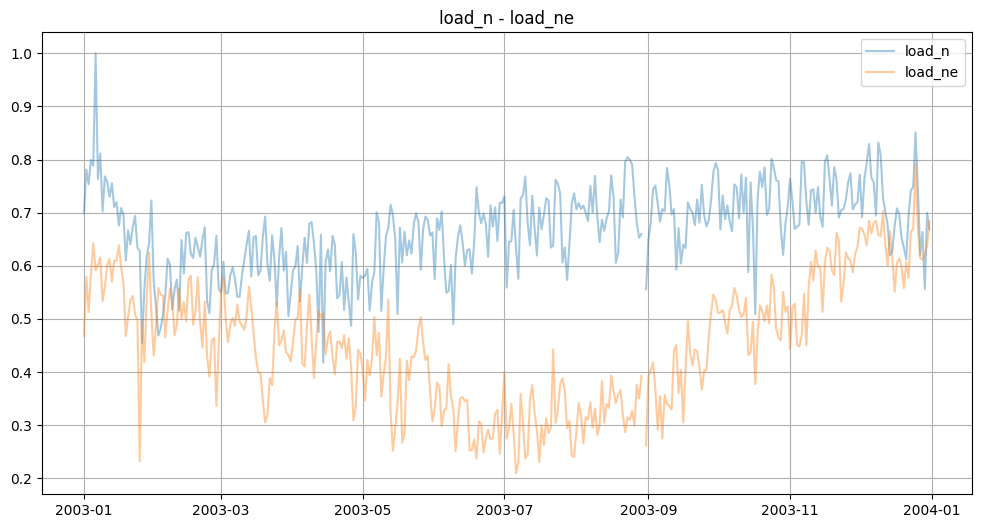

In [76]:
plot_two_by_two(normalized_data, 'load_n', 'load_ne', 1)

### Correlation Analysis

#### Autocorrelation

In [77]:
def find_acf_pacf(data, serie, lags):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    plot_acf(data[serie], lags=lags, ax=ax[0])
    plot_pacf(data[serie], lags=lags, ax=ax[1])
    plt.grid()
    plt.show()

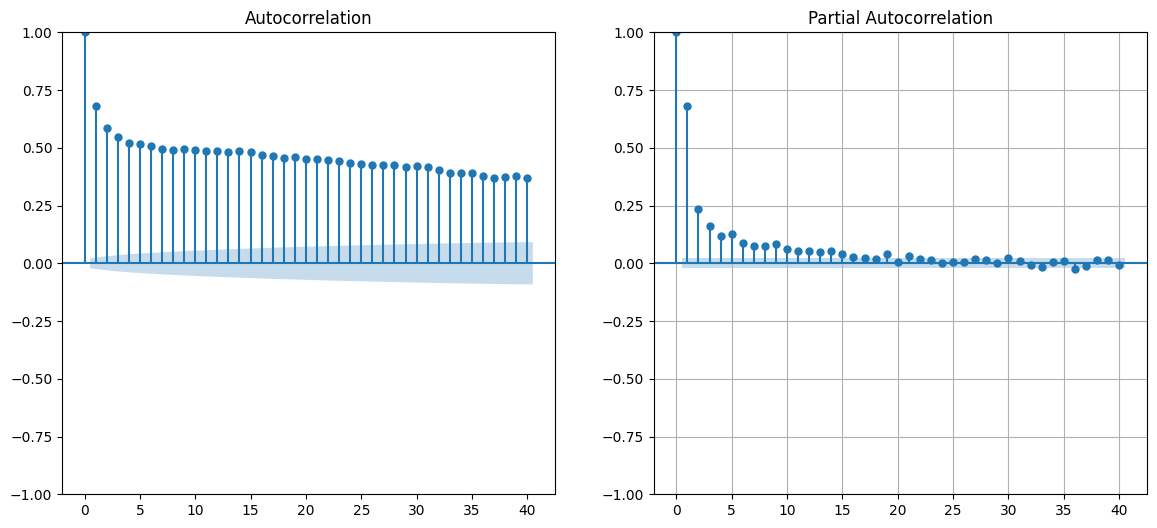

In [119]:
serie = 'load_n' 
find_acf_pacf(data, serie, 40)

#### Cross correlation

In [79]:
def correlation_analysis(data, serie1, serie2):

    # Pearson (linear) correlation
    # 1 - Perfect positive correlation (when one increases, the other also increases)
    # 0 -  No linear correlation (but can have other type of correlation)
    # -1 - Perfect negative correlation (when one increases, the other decreases)
    pearson_correlation = data.corr(method='pearson')
    plt.imshow(pearson_correlation, cmap='viridis', interpolation='nearest')
    plt.colorbar()  # Adiciona uma barra de cores
    plt.title("Pearson")
    plt.show()

    # Spearman (monotonic) Correlation
    # If the series have a non-linear relationship but follow a monotonic trend (increase or decrease together), Spearman's correlation may be more appropriate.
    spearman_correlation = data.corr(method='spearman')
    pearson_correlation = data.corr(method='pearson')
    plt.imshow(spearman_correlation, cmap='viridis', interpolation='nearest')
    plt.colorbar()  # Adiciona uma barra de cores
    plt.title("Spearman")
    plt.show()



    # Cointegração é um conceito importante em séries temporais. Duas séries são cointegradas se, apesar de serem não estacionárias individualmente, elas têm uma combinação linear que é estacionária.

    # Isso significa que, mesmo que as séries pareçam caminhar aleatoriamente (como processos estocásticos), existe uma relação de longo prazo entre elas, como se estivessem "presas" uma à outra por uma força invisível.
    # If two series are not stationary but move together in the long run, we can test for cointegration. This means that they may have an equilibrium relationship over time.
    coint_test = coint(data[serie1], data[serie2])
    print(f"Statistical test: {coint_test[0]}, p-value: {coint_test[1]}")

    # Estatística do teste: É um valor que mede a tendência de cointegração entre as séries. Ele é comparado com valores críticos da distribuição de Engle-Granger.

    # Quanto mais negativo for o valor, maior a chance de que as séries sejam cointegradas.

    #  P-Valor: Mede a significância estatística do teste.

    # Se p < 0.05, rejeitamos a hipótese nula (H₀) de que não há cointegração → As séries são cointegradas! ✅
    # Se p ≥ 0.05, não podemos rejeitar H₀ → Não há evidência de cointegração ❌

In [80]:
data.columns

Index(['load_n', 'load_ne', 'load_seco', 'load_s', 'load_t'], dtype='object')

In [81]:
# serie1= 'load_n'
# serie2= 'load_seco' 
# correlation_analysis(data, serie1, serie2)

### Histogram

In [82]:
def plot_histogram(data, ticker, bins):
    plt.hist(data[ticker], bins=bins)
    plt.ylabel('Price(Close)')
    plt.title(f'Histogram - {ticker}')
    plt.grid()
    plt.show()

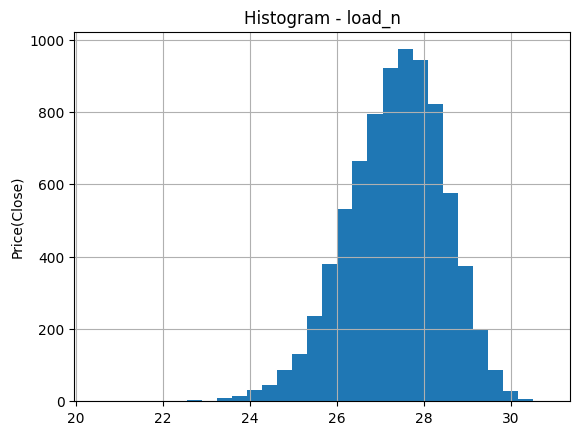

In [83]:
serie = 'load_n'
bins = 30
plot_histogram(data, serie, bins)

### Descriptive Statistics

In [84]:
print(data.describe())

            load_n      load_ne    load_seco       load_s       load_t
count  7857.000000  7857.000000  7857.000000  7856.000000  7857.000000
mean     27.348684    26.703933    24.167291    19.848925    24.517390
std       1.117281     0.915388     2.330062     4.016849     1.626609
min      20.488000    23.180819    15.204595     6.073400    19.029399
25%      26.626000    25.997203    22.416783    17.056800    23.303780
50%      27.428000    26.787812    24.454545    20.169406    24.742316
75%      28.144000    27.393007    25.984216    22.936850    25.799684
max      30.858000    31.013387    30.359041    30.974600    29.182514


### Seasonality Identification

In [85]:
def find_seasonality(data, serie):
    plot_periodogram(data[serie])
    plt.title(serie)
    plt.show()


In [86]:
# serie = 'load_n'
# find_seasonality(data, 'load_seco')

### Stationary Test

In [87]:
def find_stationarity(data):
    for serie in data.columns:
        result = adfuller(data[serie])
        print(f"Statical test: {result[0]}\np-value: {result[1]}")
        print(f'Conclusion: {serie} is stationary' if result[1]<0.05 else f"Conclusion: {serie} isn't stationary")
        print('\n')

nunca usar somente um teste.
Usar pelo menos a dupla (se complementa):
- adfuller;
- kpss;

In [88]:
# find_stationarity(data)

### Normality test

In [89]:
def find_normality(data):
    for serie in data.columns:
        stat, p = shapiro(data[serie])
        print(f'{serie} follow a normal distribution' if p>0.05 else f"{serie} doesn't follow a normal distribution\n")

In [90]:
# find_normality(data)

## Long Short-Term Memory (LSTM)

### Inputs to Analysis
In this analysis, we work with four rolling window: 30 (monthly), 90 (quaterly), 180 (biannual), 365 (annual);


In [91]:
# replace with 0
# data.fillna(0, inplace=True)
# tdrop = 'zero'
# print(data)

# replace with mean of column
data.fillna(data.mean(), inplace=True)
print(data)
tdrop = 'mean'

# replace with before value (forward fill)
# data.fillna(method='ffill', inplace=True)
# tdrop = 'ffill'

# replace with after value (backward fill)
# data.fillna(method='bfill', inplace=True)
# tdrop = 'bfill'

# rolling_window = 7

rolling_window = 30
# rolling_window = 90
# rolling_window = 180
# rolling_window = 365

# out of sample
outsample = 7

            load_n    load_ne  load_seco   load_s     load_t
eventdate                                                   
2003-01-01  27.734  26.847752  27.317682  25.8798  26.944809
2003-01-02  28.590  27.714286  26.936064  23.9826  26.805737
2003-01-03  28.304  27.197203  26.202597  23.3248  26.257150
2003-01-04  28.778  27.775624  26.108891  24.7216  26.846029
2003-01-05  28.662  28.208591  26.905095  26.4960  27.567922
...            ...        ...        ...      ...        ...
2025-01-20  26.336  26.837562  28.103497  26.8922  27.042315
2025-01-21  26.510  27.562637  28.594006  26.4166  27.270811
2025-01-22  26.404  27.709291  28.451748  25.7354  27.075110
2025-01-23  27.542  26.898701  26.309491  26.7080  26.864548
2025-01-24  25.208  27.112288  27.529670  26.1860  26.508990

[8060 rows x 5 columns]


### Univariate and One-step Methods

#### Data Preparation

In [92]:
# split a univariate sequente into samples
def split_sequence(data, serie, n_steps):
    X, y = [], []
    df = pd.DataFrame()
    df[serie] = data[serie]
    for i in range(len(df[serie])):
        end_ix = i + n_steps
        if end_ix > len(df[serie])-1:
            break
        
        seq_x, seq_y = df[serie][i:end_ix], df[serie][end_ix]
        X.append(seq_x)
        y.append(seq_y)

    return array(X), array(y)

In [93]:
serie = 'load_n'
n_steps = 30
X, y = split_sequence(data, serie, n_steps)

/tmp/ipykernel_15244/1191150512.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  seq_x, seq_y = df[serie][i:end_ix], df[serie][end_ix]


In [94]:
X[0]

array([27.734 , 28.59  , 28.304 , 28.778 , 28.662 , 30.858 , 28.402 ,
       28.904 , 27.7725, 28.454 , 28.348 , 28.056 , 28.32  , 27.856 ,
       27.95  , 27.494 , 27.838 , 27.702 , 26.814 , 27.404 , 27.132 ,
       27.468 , 27.682 , 27.06  , 27.    , 25.1975, 26.276 , 26.892 ,
       27.148 , 27.984 ])

In [95]:
X.shape

(8030, 30)

In [96]:
data['load_n']

eventdate
2003-01-01    27.734
2003-01-02    28.590
2003-01-03    28.304
2003-01-04    28.778
2003-01-05    28.662
               ...  
2025-01-20    26.336
2025-01-21    26.510
2025-01-22    26.404
2025-01-23    27.542
2025-01-24    25.208
Name: load_n, Length: 8060, dtype: float64

In [97]:
print(X[-2], y[-2])

[27.34868388 27.038      27.92       28.15       27.896      26.588
 26.792      27.258      28.358      27.938      27.654      27.17
 26.678      27.41       26.89       26.954      27.038      27.98
 27.08       26.916      27.864      25.212      26.33       26.64
 26.974      24.596      26.228      26.336      26.51       26.404     ] 27.542


In [98]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
print('Before', X.shape)
X = X.reshape(X.shape[0], X.shape[1], n_features)
print('After', X.shape)

Before (8030, 30)
After (8030, 30, 1)


In [99]:
X[-30:]

array([[[28.518     ],
        [28.796     ],
        [29.436     ],
        [29.354     ],
        [29.488     ],
        [28.64      ],
        [28.698     ],
        [28.616     ],
        [27.254     ],
        [27.298     ],
        [26.666     ],
        [26.8       ],
        [26.694     ],
        [27.514     ],
        [26.802     ],
        [27.106     ],
        [27.45      ],
        [27.012     ],
        [27.8       ],
        [27.67      ],
        [27.822     ],
        [27.742     ],
        [26.604     ],
        [27.34868388],
        [27.34868388],
        [27.34868388],
        [27.34868388],
        [27.34868388],
        [27.34868388],
        [27.038     ]],

       [[28.796     ],
        [29.436     ],
        [29.354     ],
        [29.488     ],
        [28.64      ],
        [28.698     ],
        [28.616     ],
        [27.254     ],
        [27.298     ],
        [26.666     ],
        [26.8       ],
        [26.694     ],
        [27.514     ],
        [

#### Vanilla LSTM

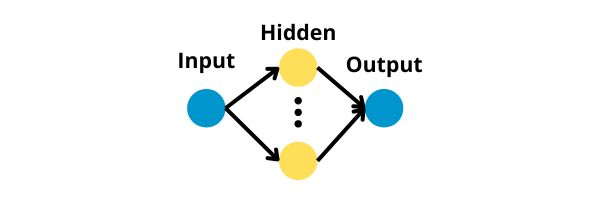

In [100]:
data['load_n']

eventdate
2003-01-01    27.734
2003-01-02    28.590
2003-01-03    28.304
2003-01-04    28.778
2003-01-05    28.662
               ...  
2025-01-20    26.336
2025-01-21    26.510
2025-01-22    26.404
2025-01-23    27.542
2025-01-24    25.208
Name: load_n, Length: 8060, dtype: float64

In [101]:
def vanilla_lstm(data, serie, n_steps):
    df = pd.DataFrame()
    df[serie] = data[serie]
    
    X, y = [], []
    for i in range(len(df[serie])):
        end_ix = i + n_steps
        if end_ix > len(df[serie]) - 1:
            break
        seq_x, seq_y = df[serie][i:end_ix], df[serie][end_ix]
        X.append(seq_x)
        y.append(seq_y)
    
    X = array(X)
    y = array(y)

    # Separando 70% treino, 15% validação e 15% teste
    train_size = int(len(X) * 0.70)
    val_size = int(len(X) * 0.15)
    # [a,b) == X[:train_size],  X[train_size]
    X_train, y_train = X[:train_size], y[:train_size]
    # [a, a+b), b < a
    # X[train_size: val_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    # before == [samples, timesteps]
    # Reshape para [samples, timesteps, features]
    n_features = 1
    # (8000, 30, 1)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], n_features)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)

    # Definição do modelo
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Treinamento do modelo com validação
    model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

    yhat = model.predict(X_test)
    mse = mean_squared_error(y_test, yhat)
    rmse = np.sqrt(mse)

    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')

    return yhat, mse, rmse

In [102]:
# rolling_window = 

In [103]:
output_analysis = pd.DataFrame()
index = ['mse', 'rmse']
output_analysis.index = pd.Index(index)

serie = 'load_n'
n_steps = rolling_window
yhat, mse, rmse = vanilla_lstm(data, serie, n_steps)
output_analysis['Vanilla'] = [mse, rmse]

/tmp/ipykernel_15244/1492177538.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  seq_x, seq_y = df[serie][i:end_ix], df[serie][end_ix]


Epoch 1/10


/home/admin/Documentos/uff/mestrado/periodo20251/pesquisa/march/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 281.5910 - val_loss: 0.6643
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7482 - val_loss: 0.5858
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6759 - val_loss: 0.5382
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6590 - val_loss: 0.5140
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6243 - val_loss: 0.5640
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6936 - val_loss: 0.5218
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6477 - val_loss: 0.5525
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6392 - val_loss: 0.5159
Epoch 9/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6588 - val_loss: 0.5870
Epoch 10/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6372 - val_loss: 0.6664
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE: 0.7930666331918591
RMSE: 0.890542886778542


In [104]:
def plot_result(data, serie, forecast, modelo, rolling_window, tdrop, isMultisteps=False):
    # Plot results
    day_past = len(forecast)

    plt.figure(figsize=(12, 6))
    
    plt.plot(data[serie].index[-day_past:], data[serie].values[-day_past:], 
             label="Real", alpha=0.6)

    # Criando eixo de tempo para previsão
    if isMultisteps:
        future_dates = pd.date_range(start=data[serie].index[-day_past], periods=day_past+3, freq="D")[1:]
    else: 
        # for the multivariate
        future_dates = pd.date_range(start=data[serie].index[-day_past], periods=day_past+1, freq="D")[1:]

    plt.plot(future_dates, yhat, label="Previsão", alpha=0.6)

    plt.xlabel("Data")
    plt.ylabel("Valor")
    plt.legend()
    plt.title(f"Previsão vs. Real - {modelo} - {rolling_window}")
    plt.grid()
    plt.savefig(f'./figures/forecast-insample-{modelo}-{rolling_window}-{tdrop}.png')
    plt.show()

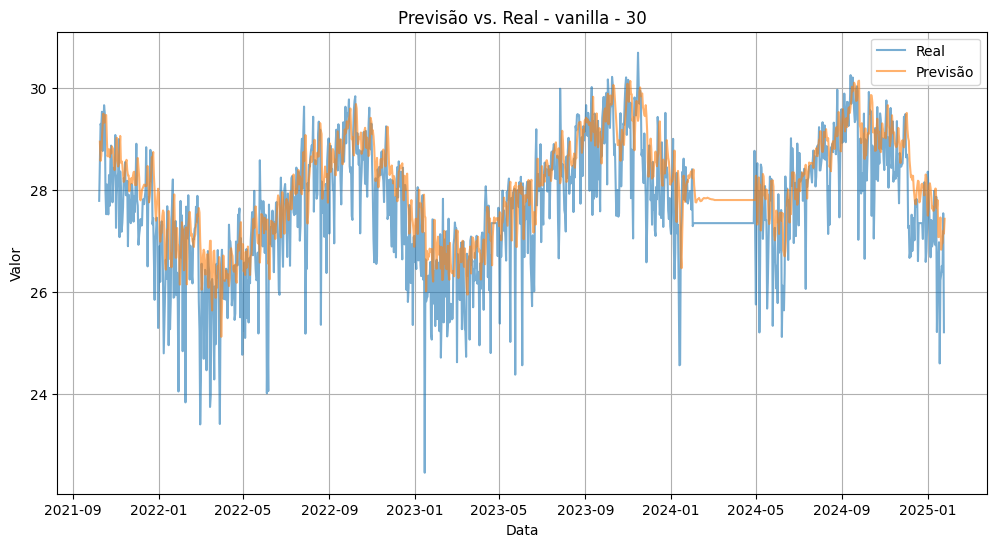

In [105]:
serie = 'load_n'
plot_result(data,serie, yhat, 'vanilla', rolling_window, tdrop)

#### Stacked LSTM

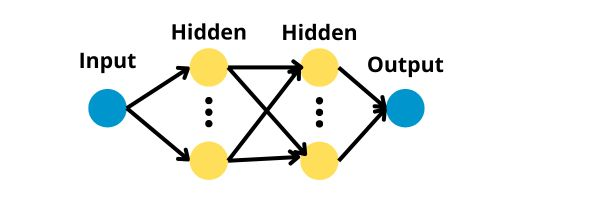

In [106]:
def stacked_lstm(data, serie, n_steps):
    df = pd.DataFrame()
    df[serie] = data[serie]
    
    X, y = [], []
    for i in range(len(df[serie])):
        end_ix = i + n_steps
        if end_ix > len(df[serie]) - 1:
            break
        seq_x, seq_y = df[serie][i:end_ix], df[serie][end_ix]
        X.append(seq_x)
        y.append(seq_y)
    
    X = array(X)
    y = array(y)

    # Separando 70% treino, 15% validação e 15% teste
    train_size = int(len(X) * 0.70)
    val_size = int(len(X) * 0.15)

    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    # Reshape para [samples, timesteps, features]
    n_features = 1
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], n_features)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)

    # Definição do modelo
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Treinamento do modelo com validação
    model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

    yhat = model.predict(X_test)
    mse = mean_squared_error(y_test, yhat)
    rmse = np.sqrt(mse)

    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')

    return yhat, mse, rmse

In [107]:
serie = 'load_n'
n_steps = 30
yhat, mse, rmse = stacked_lstm(data, serie, n_steps)
output_analysis['Stacked'] = [mse, rmse]

/tmp/ipykernel_15244/2952749914.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  seq_x, seq_y = df[serie][i:end_ix], df[serie][end_ix]


Epoch 1/10


/home/admin/Documentos/uff/mestrado/periodo20251/pesquisa/march/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 9.2671 - val_loss: 0.6845
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.8202 - val_loss: 0.8717
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.7937 - val_loss: 0.8641
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.7639 - val_loss: 0.5754
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.7608 - val_loss: 0.5578
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.7056 - val_loss: 0.7154
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 64.5389 - val_loss: 0.9972
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.9399 - val_loss: 0.8007
Epoch 9/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.7704 - val_loss: 0.6220
Epoch 10/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.7517 - val_loss: 0.6072
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MSE: 0.7267129470534325
RMSE: 0.8524746019990463


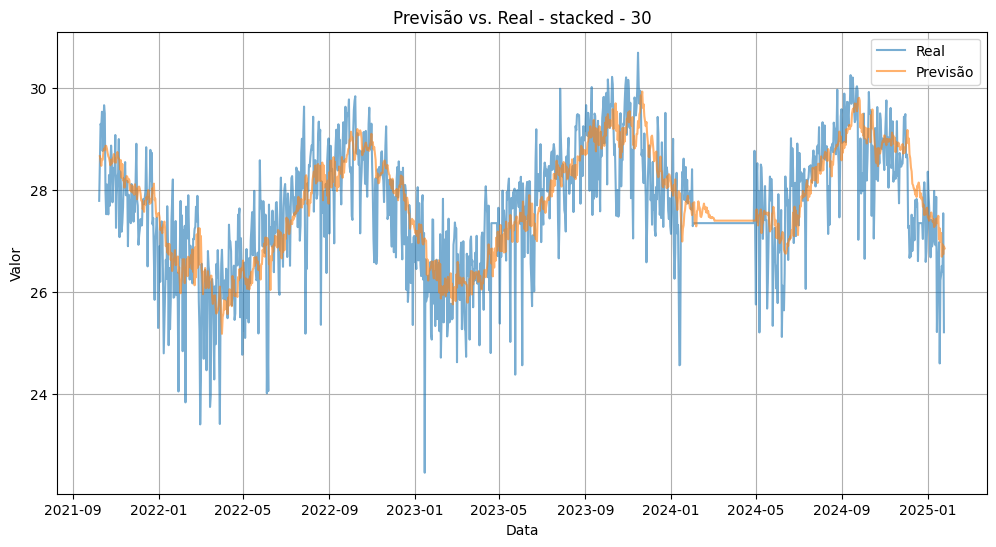

In [108]:
serie='load_n'
plot_result(data, serie, yhat, 'stacked', rolling_window, tdrop)

### Multivariate LSTM Models

#### Multiple Input Series

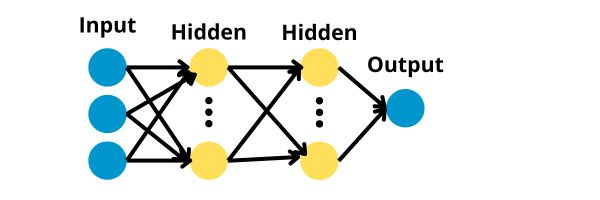

In [109]:
# multivariate lstm example
def multiple_input_lstm(data, serie1, serie2, serie3, n_steps):
    # split a multivariate sequence into samples
    
    df = pd.DataFrame()
    df[serie1] = data[serie1]
    df[serie2] = data[serie2]
    df[serie3] = data[serie3]

    df = df

    in_seq1 = array(df[serie1])
    in_seq2 = array(df[serie2])
    in_seq3 = array(df[serie3])

    # convert to [rows, columns]
    in_seq1 = in_seq1.reshape((len(in_seq1), 1))
    in_seq2 = in_seq2.reshape((len(in_seq2), 1))
    in_seq3 = in_seq3.reshape((len(in_seq3), 1))

    dataset = hstack((in_seq1, in_seq2, in_seq3))

    X, y = [], []
    for i in range(len(dataset)):
        end_ix = i + n_steps

        if end_ix > len(dataset):
            break
        seq_x, seq_y = dataset[i:end_ix, :-1], dataset[end_ix -1, -1]
        X.append(seq_x)
        y.append(seq_y)

    X, y  = array(X), array(y)

    train_size = int(len(X) * 0.70)
    val_size = int(len(X) * 0.15)

    X_train, y_train = X[:train_size, ], y[:train_size]
    X_val, y_val = X[train_size:train_size+val_size, ], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size+val_size: , ], y[train_size + val_size:]


    # define model - Stack
    n_features = X.shape[2]
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # fit model
    model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

    yhat = model.predict(X_test)
    mse = mean_squared_error(y_test, yhat)
    rmse = np.sqrt(mse)

    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')

    return yhat, mse, rmse

In [110]:
# choose a number of time steps
n_steps = 30

# serial inputs
serie1 = 'load_ne'
serie2 = 'load_seco'

# serial inputs/target
serie3 = 'load_n'
yhat, mse, rmse = multiple_input_lstm(data, serie1, serie2, serie3, n_steps)
output_analysis['Multiple_Input'] = [mse, rmse]

Epoch 1/10


/home/admin/Documentos/uff/mestrado/periodo20251/pesquisa/march/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 183.1047 - val_loss: 2.0105
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.8879 - val_loss: 1.3925
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.8380 - val_loss: 1.3061
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.3575 - val_loss: 0.9434
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.2466 - val_loss: 0.9728
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.2192 - val_loss: 0.9446
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.1622 - val_loss: 1.0128
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.1519 - val_loss: 1.3531
Epoch 9/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.2252 - val_loss: 0.9612
Epoch 10/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.1869 - val_loss: 0.8510
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
MSE: 1.4270572147835632
RMSE: 1.194595000317498


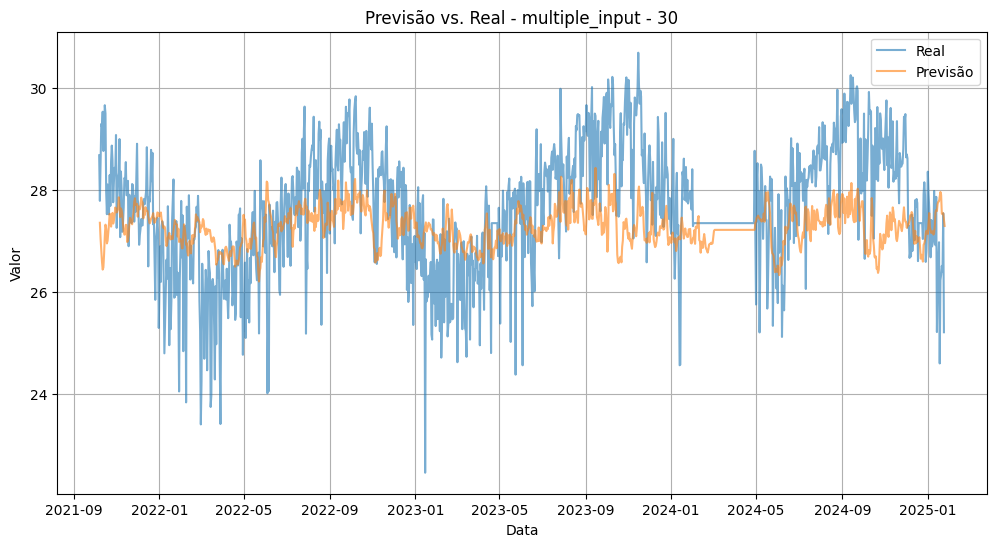

In [111]:
serie = 'load_n'
plot_result(data, serie, yhat, 'multiple_input', rolling_window, tdrop)

#### Multiple Parallel Series

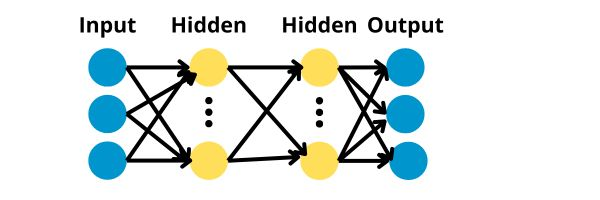

In [112]:
# multivariate parallel series lstm example
def multiple_parallel_series_lstm(data, serie1, serie2, serie3, n_steps):
    # split a multivariate sequence into samples
    
    df = pd.DataFrame()
    df[serie1] = data[serie1]
    df[serie2] = data[serie2]
    df[serie3] = data[serie3]

    df = df

    in_seq1 = array(df[serie1])
    in_seq2 = array(df[serie2])
    in_seq3 = array(df[serie3])

    # convert to [rows, columns]
    in_seq1 = in_seq1.reshape((len(in_seq1), 1))
    in_seq2 = in_seq2.reshape((len(in_seq2), 1))
    in_seq3 = in_seq3.reshape((len(in_seq3), 1))

    dataset = hstack((in_seq1, in_seq2, in_seq3))

    X, y = [], []
    for i in range(len(dataset)):
        end_ix = i + n_steps

        if end_ix > len(dataset):
            break
        seq_x, seq_y = dataset[i:end_ix, :], dataset[end_ix-1, ]
        X.append(seq_x)
        y.append(seq_y)

    X, y  = array(X), array(y)

    train_size = int(len(X) * 0.70)
    val_size = int(len(X) * 0.15)

    X_train, y_train = X[:train_size, ], y[:train_size]
    X_val, y_val = X[train_size:train_size+val_size, ], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size+val_size: , ], y[train_size + val_size:]


    # define model - Stack
    n_features = X.shape[2]
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(n_features))
    model.compile(optimizer='adam', loss='mse')

    # fit model
    model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

    # evaluate model
    test_loss = model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss}")

    # predict
    x_input = array(X[-n_steps: , -1])
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input)
    print(f'Real: {y[-1]}')
    print(f'Previsto: {yhat}')

In [113]:
# choose a number of time steps
n_steps = 30

# serial inputs
serie1 = 'load_ne'
serie2 = 'load_seco'

# serial inputs/target
serie3 = 'load_n'
# multiple_parallel_series_lstm(data, serie1, serie2, serie3, n_steps)

In [114]:
# choose a number of time steps
n_steps = 90

# serial inputs
serie1 = 'load_ne'
serie2 = 'load_seco'

# serial inputs/target
serie3 = 'load_n'
# multiple_parallel_series_lstm(data, serie1, serie2, serie3, n_steps)

### Multi-Step LSTM Models

#### Vector (Univariate) Output Model

In [115]:
# split a univariate sequence into samples
def split_sequence(data, serie, n_steps_in, n_steps_out):
    df = pd.DataFrame()
    df[serie] = data[serie]
    X, y = [], []
    for i in range(len(df[serie])):
        end_ix = i+n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(df[serie]):
            break
        
        seq_x, seq_y = df[serie][i:end_ix], df[serie][end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)

    return array(X), array(y)
        

In [116]:
serie = 'load_n'
n_steps_in, n_steps_out = 30, 10
X, y = split_sequence(data, serie, n_steps_in, n_steps_out)

In [117]:
# univariate multi-step vector-output stacked LSTM
def univariate_multistep_vector_output(data, serie, n_steps_in, n_steps_out):
    df = pd.DataFrame()
    df[serie] = data[serie]

    X, y = [], []

    for i in range(len(df[serie])):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(df[serie]):
            break

        seq_x, seq_y = df[serie][i:end_ix], df[serie][end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X, y = np.array(X), np.array(y)

    # Split train, val, test
    train_size = int(len(X) * 0.70)
    val_size = int(len(X) * 0.15)

    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    # Reshape for LSTM
    n_features = 1
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

    # Define model
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')

    # Fit model
    model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

    yhat_insample = model.predict(X_test)
    mse = mean_squared_error(y_test, yhat_insample)
    rmse = np.sqrt(mse)

    # Predict next steps
    x_input = np.array(df[-n_steps_in:])  # Pegando os últimos valores da série
    x_input = x_input.reshape((1, n_steps_in, n_features))
    yhat_outsample = model.predict(x_input)  # Pega apenas a previsão

    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')

    return yhat_insample, yhat_outsample, mse, rmse

In [118]:
serie = 'load_n'
n_steps_in, n_steps_out = rolling_window, outsample
yhat_insample, yhat_outsample, mse, rmse = univariate_multistep_vector_output(data, serie, n_steps_in, n_steps_out)
output_analysis['Univariate_Multistep'] = [mse, rmse]

Epoch 1/10


/home/admin/Documentos/uff/mestrado/periodo20251/pesquisa/march/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 150.8182 - val_loss: 0.6728
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.7653 - val_loss: 1.2163
Epoch 3/10
121/176 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8293

KeyboardInterrupt: 

In [57]:
yhat_insample.shape

(1208, 7)

ValueError: x and y must have same first dimension, but have shapes (1210,) and (1206, 1)

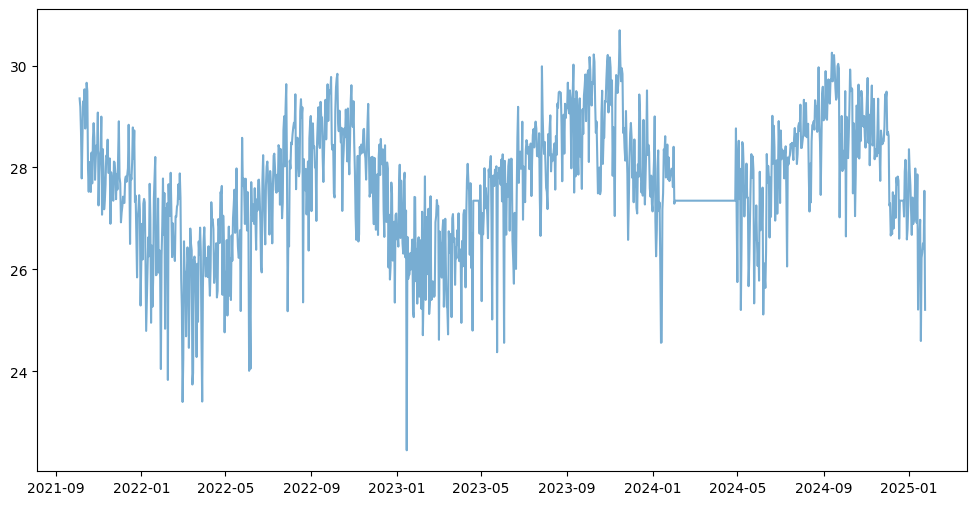

In [58]:
serie = 'load_n'
plot_result(data, serie, yhat_insample, 'univariate_multisteps', rolling_window, tdrop, isMultisteps=True)

In [ ]:
def plot_result_future(data,serie, forecast, modelo, rolling_window, tdrop):
    # Plot results
    day_past = len(forecast)

    plt.figure(figsize=(12, 6))
    
    plt.plot(data[serie].index[-(day_past + 200):], data[serie].values[-(day_past + 200):], 
             label="Real", alpha=0.5)

    # Criando eixo de tempo para previsão
    future_dates = pd.date_range(data[serie].index[-1], periods=day_past+1, freq="D")[1:]

    future_dates = pd.date_range(start=data[serie].index[-1], periods=(day_past+1), freq="D")[1:]

    # Se necessário, transforma forecast em um vetor 1D
    forecast = forecast.flatten() 

    plt.plot(future_dates, forecast, label="Previsão", markersize=3)

    plt.xlabel("Data")
    plt.ylabel("Valor")
    plt.legend()
    plt.title(f"Previsão vs. Real - {modelo} - {rolling_window}")
    plt.grid()
    plt.savefig(f'./figures/forecast-outsample-{modelo}-{rolling_window}-{day_past}.png')
    plt.show()


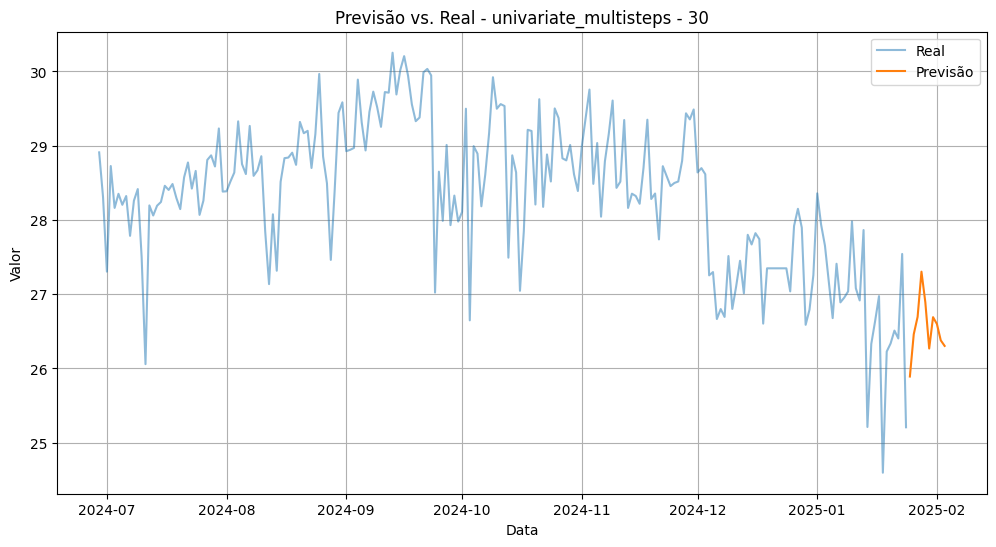

In [ ]:
serie = 'load_n'
plot_result_future(data, serie, yhat_outsample[0], 'univariate_multisteps', rolling_window, tdrop)

#### Vector (Multivariate) Output Model

In [ ]:
# split sequence into samples
def split_sequences(data,serie1, serie2, serie3, n_steps_in, n_steps_out):
    serie1 = array(data[serie1])
    serie2 = array(data[serie2])
    serie3 = array(data[serie3])

    # converto to [rows, columns] structure
    serie1 = serie1.reshape((len(serie1), 1))
    serie2 = serie2.reshape((len(serie2), 1))
    serie3 = serie3.reshape((len(serie3), 1))

    dataset = hstack((serie1, serie2, serie3))
    

    X, y = [], []
    for i in range(len(dataset)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(dataset):
            break

        seq_x, seq_y = dataset[i:end_ix, :], dataset[end_ix: out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    
    print('\ndataset: ')
    print(dataset[n_steps_in:n_steps_in+6])
    print('\nX: ')
    print(X[n_steps_in][:5])
    print('\ny: ')
    print(y[0][:5])

    X = array(X)
    y = array(y)

    print(f'Shape(X): {X.shape}')
    print(f'Shape(y): {y.shape}')

    # return array(X), array(y)

In [ ]:
serie1 = 'load_ne'
serie2 = 'load_seco'
serie3 = 'load_n'

n_steps_in, n_steps_out = 30, 10
split_sequences(data,serie1, serie2, serie3, n_steps_in, n_steps_out)


dataset: 
[[26.55744256 26.47412587 26.41      ]
 [26.98221778 27.44375624 25.908     ]
 [27.55324675 28.27472527 25.348     ]
 [27.45674326 27.77822178 25.482     ]
 [27.43996004 27.9966034  25.754     ]
 [26.82757243 27.52507493 26.132     ]]

X: 
[[26.55744256 26.47412587 26.41      ]
 [26.98221778 27.44375624 25.908     ]
 [27.55324675 28.27472527 25.348     ]
 [27.45674326 27.77822178 25.482     ]
 [27.43996004 27.9966034  25.754     ]]

y: 
[26.41  25.908 25.348 25.482 25.754]
Shape(X): (8021, 30, 3)
Shape(y): (8021, 10)


In [ ]:
# multivariate multi-step vector-output stacked LSTM
def multivariate_multistep_vector_output(data, serie1, serie2, serie3, n_steps_in, n_steps_out):

    # target --> serie3
    serie1 = array(data[serie1])
    serie2 = array(data[serie2])
    serie3 = array(data[serie3])

    # converto to [rows, columns] structure
    serie1 = serie1.reshape((len(serie1), 1))
    serie2 = serie2.reshape((len(serie2), 1))
    serie3 = serie3.reshape((len(serie3), 1))

    dataset = hstack((serie1, serie2, serie3))
    

    X, y = [], []
    for i in range(len(dataset)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(dataset):
            break

        seq_x, seq_y = dataset[i:end_ix, :], dataset[end_ix: out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)

    X = array(X)
    y = array(y)

    # Split train, val, test
    train_size = int(len(X) * 0.70)
    val_size = int(len(X) * 0.15)

    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    # Reshape for LSTM
    n_features = X.shape[2]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

    # Define model
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')

    # Fit model
    model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

    yhat_insample = model.predict(X_test)
    mse = mean_squared_error(y_test, yhat_insample)
    rmse = np.sqrt(mse)

    # Predict next steps
    x_input = np.array(dataset[-n_steps_in:])  # Pegando os últimos valores da série
    x_input = x_input.reshape((1, n_steps_in, n_features))
    yhat_outsample = model.predict(x_input)  # Pega apenas a previsão

    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')

    return yhat_insample, yhat_outsample, mse, rmse

In [ ]:
serie1 = 'load_ne'
serie2 = 'load_seco'
serie3 = 'load_n'

n_steps_in, n_steps_out = 30, 10
yhat_insample, yhat_outsample, mse, rmse = multivariate_multistep_vector_output(data,serie1, serie2, serie3, n_steps_in, n_steps_out)
output_analysis['Multivariate_Multisteps'] = [mse, rmse]

Epoch 1/10


/home/brenddon/Documents/uff/mestrado/periodo20251/pesquisa/march/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 83.9176 - val_loss: 1.1071
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 1.3836 - val_loss: 0.9724
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.9910 - val_loss: 0.7517
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.9082 - val_loss: 0.8091
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.9542 - val_loss: 0.6967
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.9780 - val_loss: 0.8644
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.9461 - val_loss: 0.9971
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.8366 - val_loss: 1.4178
Epoch 9/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.9898 - val_loss: 0.6862
Epoch 10/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.8472 - val_loss: 0.7691
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MSE: 0.9105311599652625
RMSE: 0.9542175642720387


In [ ]:
output_analysis

,Vanilla,Stacked,Multiple_Input,Univariate_Multistep,Multivariate_Multisteps
mse,0.633799,0.626339,1.998140,0.858284,0.910531
rmse,0.796115,0.791416,1.413556,0.926436,0.954218


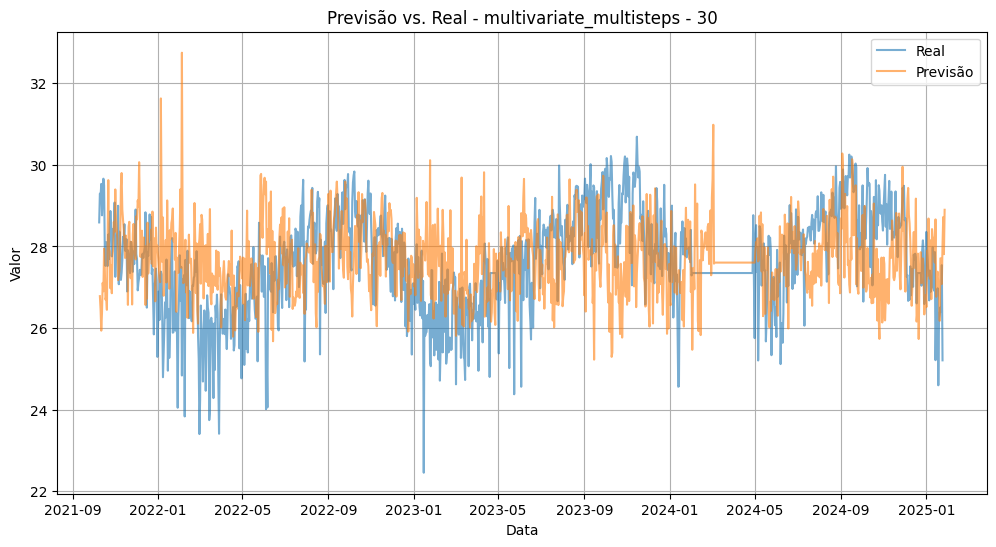

In [ ]:
serie = 'load_n'
plot_result(data, serie, yhat_insample, 'multivariate_multisteps', rolling_window, tdrop, isMultisteps=True)

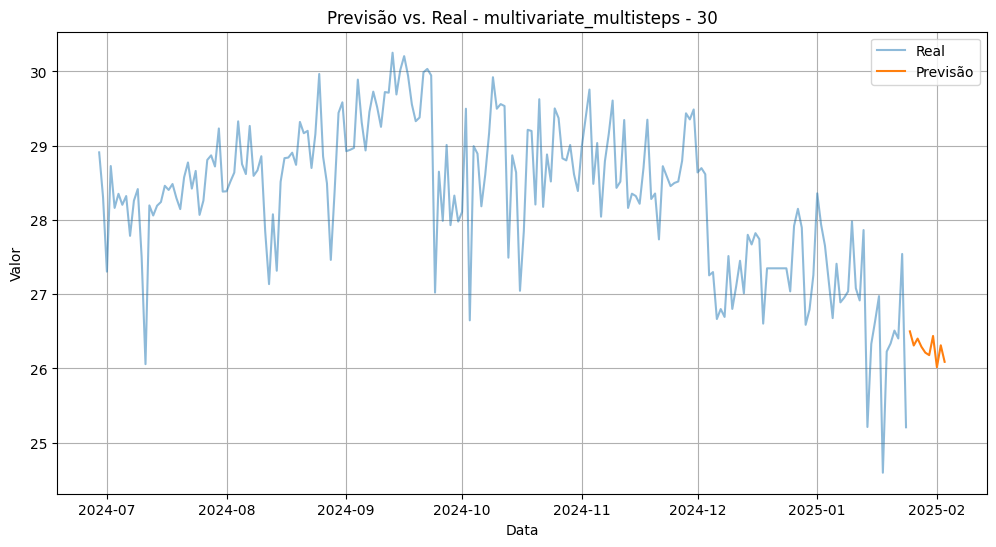

In [ ]:
serie = 'load_n'
plot_result_future(data, serie, yhat_outsample[0], 'multivariate_multisteps', rolling_window, tdrop)

In [ ]:
output_analysis

,Vanilla,Stacked,Multiple_Input,Univariate_Multistep,Multivariate_Multisteps
mse,0.633799,0.626339,1.998140,0.858284,0.910531
rmse,0.796115,0.791416,1.413556,0.926436,0.954218


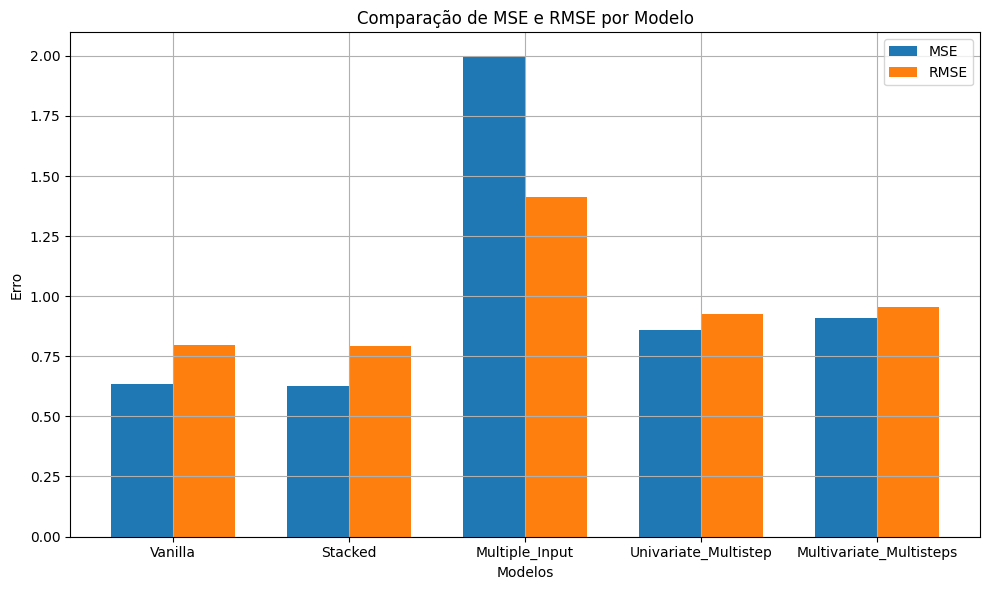

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dados
data = {
    'Vanilla': [0.633799, 0.796115],
    'Stacked': [0.626339, 0.791416],
    'Multiple_Input': [1.998140, 1.413556],
    'Univariate_Multistep': [0.858284, 0.926436],
    'Multivariate_Multisteps': [0.910531, 0.954218]
}

# Definindo as métricas (mse, rmse)
metrics = ['mse', 'rmse']

# Organizando os dados em um formato que podemos usar
data_values = np.array(list(data.values()))  # Cada linha será um modelo e cada coluna será uma métrica

# Definindo as posições no eixo X
x = np.arange(len(data))  # Posições para cada modelo
width = 0.35  # Largura das barras

fig, ax = plt.subplots(figsize=(10, 6))

# Plotando as barras para cada métrica
bars1 = ax.bar(x - width/2, data_values[:, 0], width, label='MSE')
bars2 = ax.bar(x + width/2, data_values[:, 1], width, label='RMSE')

# Adicionando título e rótulos
ax.set_xlabel('Modelos')
ax.set_ylabel('Erro')
ax.set_title('Comparação de MSE e RMSE por Modelo')
ax.set_xticks(x)
ax.set_xticklabels(data.keys())
ax.legend()

# Exibindo o gráfico
plt.tight_layout()
plt.grid()
plt.savefig(f'./figures/histograma-{rolling_window}-{tdrop}.png')

plt.show()


#### Direct Model

In [ ]:
# multivariate multi-step stack direct method LSTM
def multivariate_multistep_dict_output(data, serie1, serie2, serie3, n_steps_in, n_steps_out):

    # target --> serie3
    serie1 = array(data[serie1])
    serie2 = array(data[serie2])
    serie3 = array(data[serie3])

    # converto to [rows, columns] structure
    serie1 = serie1.reshape((len(serie1), 1))
    serie2 = serie2.reshape((len(serie2), 1))
    serie3 = serie3.reshape((len(serie3), 1))

    dataset = hstack((serie1, serie2, serie3))
    

    X, y = [], []
    for i in range(len(dataset)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(dataset):
            break

        seq_x, seq_y = dataset[i:end_ix, :], dataset[end_ix: out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)

    X = array(X)
    y = array(y)

    # Split train, val, test
    train_size = int(len(X) * 0.70)
    val_size = int(len(X) * 0.15)

    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    # Reshape for LSTM
    n_features = X.shape[2]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

    # Define models for each step time
    list_test_error = []
    models = []
    for i in range(n_steps_out):
        print(f'\n\nTraining model: {i}')
        model = Sequential()
        model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
        model.add(LSTM(100, activation='relu'))
        # each model forecasting one time step
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        # Fit model
        model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))


        models.append(model)


    # Predict next steps
    for i, model in enumerate(models):
        yhat_insample = model.predict(X_test)
        mse = mean_squared_error(y_test, yhat_insample)
        rmse = np.sqrt(mse)

        # Predict next steps
        x_input = np.array(dataset[-n_steps_in:])  # Pegando os últimos valores da série
        x_input = x_input.reshape((1, n_steps_in, n_features))
        yhat_outsample = model.predict(x_input)  # Pega apenas a previsão

        print(f'MSE: {mse}')
        print(f'RMSE: {rmse}')

        return yhat_insample, yhat_outsample, mse, rmse


In [ ]:
# # multivariate multi-step stack direct method LSTM
# def multivariate_multistep_dict_output(data, serie1, serie2, serie3, n_steps_in, n_steps_out):

#     # target --> serie3
#     serie1 = array(data[serie1])
#     serie2 = array(data[serie2])
#     serie3 = array(data[serie3])

#     # converto to [rows, columns] structure
#     serie1 = serie1.reshape((len(serie1), 1))
#     serie2 = serie2.reshape((len(serie2), 1))
#     serie3 = serie3.reshape((len(serie3), 1))

#     dataset = hstack((serie1, serie2, serie3))
    

#     X, y = [], []
#     for i in range(len(dataset)):
#         end_ix = i + n_steps_in
#         out_end_ix = end_ix + n_steps_out

#         if out_end_ix > len(dataset):
#             break

#         seq_x, seq_y = dataset[i:end_ix, :], dataset[end_ix: out_end_ix, -1]
#         X.append(seq_x)
#         y.append(seq_y)

#     X = array(X)
#     y = array(y)

#     # Split train, val, test
#     train_size = int(len(X) * 0.70)
#     val_size = int(len(X) * 0.15)

#     X_train, y_train = X[:train_size], y[:train_size]
#     X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
#     X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

#     # Reshape for LSTM
#     n_features = X.shape[2]
#     X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
#     X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
#     X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

#     # Define models for each step time
#     list_test_error = []
#     models = []
#     for i in range(n_steps_out):
#         print(f'\n\nTraining model: {i}')
#         model = Sequential()
#         model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
#         model.add(LSTM(100, activation='relu'))
#         # each model forecasting one time step
#         model.add(Dense(1))
#         model.compile(optimizer='adam', loss='mse')

#         # Fit model
#         model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))


#         models.append(model)


#     # Predict next steps
#     predictions = []
#     for i, model in enumerate(models):
#         x_input = np.array(dataset[-n_steps_in:])  # Pegando os últimos valores da série
#         x_input = x_input.reshape((1, n_steps_in, n_features))
#         yhat = model.predict(x_input)[0]  # Pega apenas a previsão
#         predictions.append(float(yhat[0]))

#     return predictions

In [ ]:
# serie1 = 'load_ne'
# serie2 = 'load_seco'
# serie3 = 'load_n'

# n_steps_in, n_steps_out = 30, 10
# yhat_insample, yhat_outsample, mse, rmse = multivariate_multistep_dict_output(data,serie1, serie2, serie3, n_steps_in, n_steps_out)
# output_analysis['multivariate_multisteps_direct'] = [mse, rmse]

In [ ]:
# serie = 'load_n'
# plot_result(data, serie, yhat_insample, 'multivariate_multisteps_direct', rolling_window, isMultisteps=True)

In [ ]:
# serie = 'load_n'
# plot_result_future(data, serie, yhat_outsample[0], 'multivariate_multisteps_direct', rolling_window)

- Retirar os dropnan() 
- usar as métricas mse e rmse 
- prestar atenção na divisão X_train, y_train, X_test e y_test 
- comprar a y_test com o seu forecast (aqui que se aplica as métricas de erros)

<!-- Retirar os dropnan() 
usar as métricas mse e rmse 
 prestar atenção na divisão X_train, y_train, X_test e y_test 
comprar a y_test com o seu forecast (aqui que se aplica as métricas de erros) -->

In [ ]:
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/
 
# https://machinelearningmastery.com/multi-step-time-series-forecasting/
# 4 Strategies for Multi-Step Time Series Forecasting - MachineLearningMastery.com
# Time series forecasting is typically discussed where only a one-step prediction is required. What about when you need to predict multiple time steps into the future? Predicting multiple time steps ...
 
# fazer uma análise de resíduo
# como fazer análise de resíduo
# tirar a parte pós 2024 (onde tem NaN)